In [1]:
# Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

# Graphic libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [2]:
# Initialization
sns.set()

url = "https://github.com/renatoquiliche/Insurance-Mathematics-Economics-ADR/blob/main/Databases/insurance.csv?raw=true"

data_insurance = pd.read_csv(url)

# Data pre-processing

In [3]:
categorical = pd.get_dummies(data_insurance[["sex","smoker"]]) 
numerical = data_insurance[["age","bmi","children", "charges"]]

scaler = RobustScaler()

#Escalamos la data numerica a la escala de la binaria
numerical_data_scaled = pd.DataFrame(scaler.fit_transform(numerical), columns=["age","bmi","children", "charges"])

#Unimos los dos tipos de data
final_data_scaled = pd.concat([numerical_data_scaled, categorical], axis=1)

In [4]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=1000, early_exaggeration=12,
            init='pca', learning_rate='auto', method='barnes_hut', n_jobs=-1, random_state=0)
vecs_list_tsne = tsne.fit_transform(final_data_scaled)

print("Training error: ", tsne.kl_divergence_)

Training error:  0.5130044221878052


In [15]:
tsne_error = {'n_components': [], 'error':[]}
for i in [1, 2, 3]:
    tsne = TSNE(n_components=i, perplexity=50, n_iter=1000, early_exaggeration=12,
            init='pca', learning_rate='auto', method='barnes_hut', n_jobs=-1, random_state=0)
    vecs_list_tsne = tsne.fit_transform(final_data_scaled)

    print("Training error: ", tsne.kl_divergence_)
    tsne_error['n_components'].append(i)
    tsne_error['error'].append(tsne.kl_divergence_)

Training error:  0.8310343623161316
Training error:  0.5130044221878052
Training error:  0.36717888712882996


<AxesSubplot: >

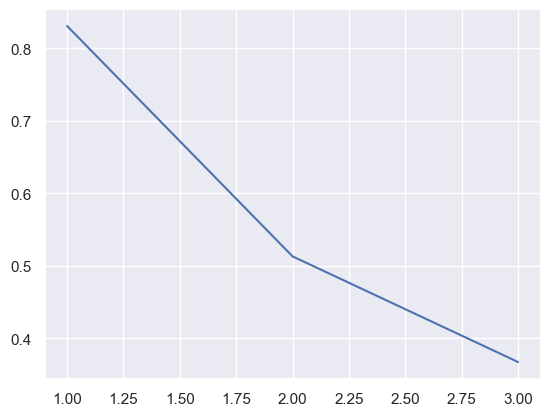

In [16]:
sns.lineplot(x=tsne_error['n_components'], y=tsne_error['error'])

In [18]:
import plotly.express as px

# Create a 3D scatterplot using plotly
fig = px.scatter_3d(x=vecs_list_tsne[:,0], y=vecs_list_tsne[:,1], z=vecs_list_tsne[:,1])

# Show the plot
fig.show()

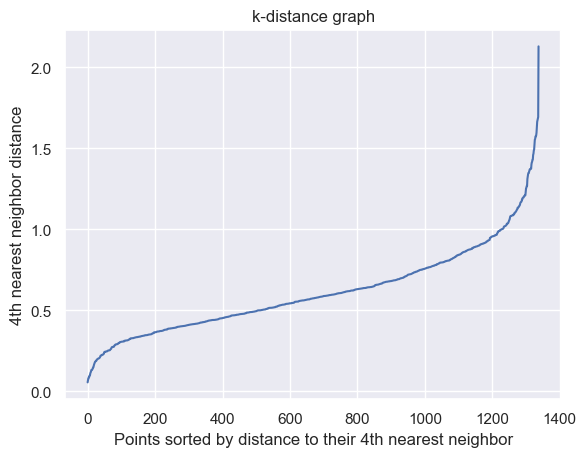

Estimated optimal eps value: 2.129


In [32]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
# Compute the k-distance for each point using the k-nearest neighbors algorithm
knn = NearestNeighbors(n_neighbors=4)
knn.fit(vecs_list_tsne)
distances, indices = knn.kneighbors(vecs_list_tsne)
k_distance = np.sort(distances[:, 3], axis=0)

# Plot the k-distance graph
plt.plot(k_distance)
plt.xlabel('Points sorted by distance to their 4th nearest neighbor')
plt.ylabel('4th nearest neighbor distance')
plt.title('k-distance graph')
plt.show()

# Use the elbow method to estimate the optimal eps value
# The optimal eps value corresponds to the knee point in the graph
knee = np.diff(k_distance, n=2)
optimal_eps = k_distance[np.argmax(knee) + 2]
print(f"Estimated optimal eps value: {optimal_eps:.3f}")

In [33]:
from sklearn.cluster import DBSCAN
components = pd.DataFrame(vecs_list_tsne, columns=['tsne1', 'tsne2', 'tsne3'])
DBSCAN = DBSCAN(eps=2.129, min_samples=4)
DBSCAN.fit(components)

data_insurance["DBSC"] = DBSCAN.labels_

fig = px.scatter_3d(x=vecs_list_tsne[:,0], y=vecs_list_tsne[:,1], z=vecs_list_tsne[:,1], color=DBSCAN.labels_)
fig.show()

# Prescription

In [37]:
data_insurance

,age,sex,bmi,children,smoker,region,charges,DBSC,BMI
0,19,female,27.900,0,yes,southwest,16884.92400,0,Non-obesity(BMI<30)
1,18,male,33.770,1,no,southeast,1725.55230,1,Obesity(BMI>30)
2,28,male,33.000,3,no,southeast,4449.46200,1,Obesity(BMI>30)
3,33,male,22.705,0,no,northwest,21984.47061,1,Non-obesity(BMI<30)
4,32,male,28.880,0,no,northwest,3866.85520,1,Non-obesity(BMI<30)
...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,1,Obesity(BMI>30)
1334,18,female,31.920,0,no,northeast,2205.98080,2,Obesity(BMI>30)
1335,18,female,36.850,0,no,southeast,1629.83350,2,Obesity(BMI>30)
1336,21,female,25.800,0,no,southwest,2007.94500,2,Non-obesity(BMI<30)


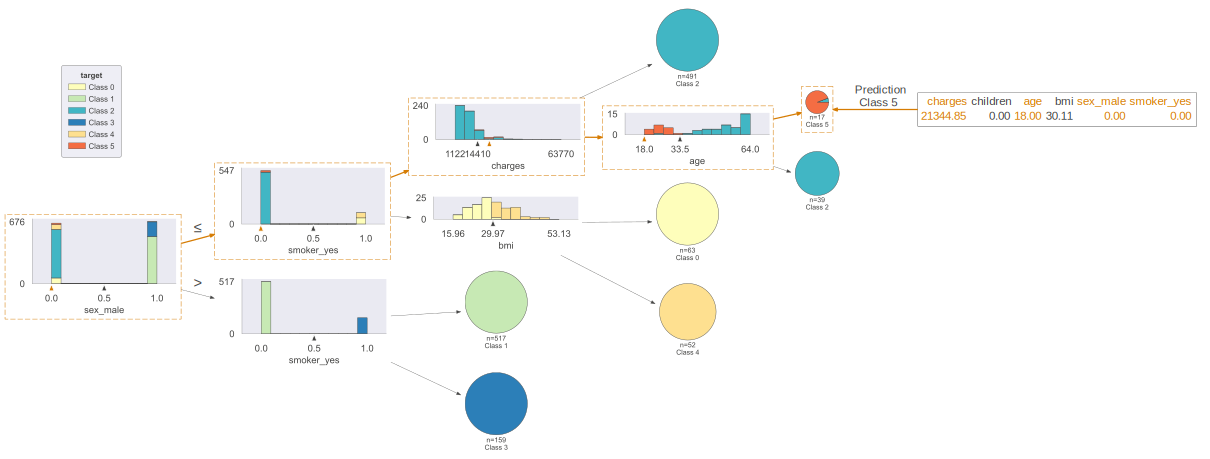

In [105]:
from sklearn.tree import DecisionTreeClassifier

categorical = pd.get_dummies(data_insurance[["sex", "smoker"]], drop_first=True)
numerical = data_insurance[["charges", "children", "age", "bmi"]]
DecisionTree = DecisionTreeClassifier(max_leaf_nodes=None, criterion="entropy", random_state=0, max_depth=4)

x = pd.concat([numerical, categorical], axis=1)
y = data_insurance["DBSC"]

DecisionTree.fit(x, y)

import dtreeviz # remember to load the package

viz = dtreeviz.model(DecisionTree, x, y,
                target_name="target",
                feature_names=x.columns.values)
viz.view(orientation="LR", scale=1.05, x=x.iloc[102], ticks_fontsize=12, title_fontsize=12, label_fontsize=12)